# Feedforward Neural Networks 


Todays goals are to be able to...

1. Describe the structure of a feedforward neural network
2. Convert between mathematical descriptions, visual diagrams, and PyTorch code that represent Feedforward Networks
3. Implement feedforward NN architectures in PyTorch

## Today's Activity

We will do this through an implementation of [Bengio et al. (2000)](https://proceedings.neurips.cc/paper_files/paper/2000/hash/728f206c2a01bf572b5940d7d9a8fa4c-Abstract.html) Neural Trigram Model, as a way to revisit the world of N-grams! 

For the most part, this is meant as an interactive tutorial, rather than a formal assignment. I'd like you to explore the code below to understand the inner mechanics of the provided classes and functions. In particular, I'd like you to use the official [PyTorch Documentation] as a reading guide for all of the PyTorch code below!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

To return to N-Gram land, lets load in Emma once again. Here is a brief (and coarse) split of Emma into a train and test set. Note that I don't even split on a sentence boundary (this is broadly bad form!)

In [ ]:
with open("austen-emma.txt") as train_f:
    data = train_f.read().lower().split()

train = data[:160000]
valid = data[160000:]

And here is a sample of preprocessing code for an n-gram model: a method to split data into to n-gram tuples and code to add the appropriate padding between sentences.

In [ ]:
def get_ngrams(data, n):
    for i in range(len(data) - n + 1):
        yield tuple(data[i:i+n])

def pad(tokens, n, eos="<eos>"):
     if n <= 1: return tokens
     out_tokens = []
     for w in tokens:
         if w == eos:
             out_tokens += [eos] * (n-1)
             continue
         out_tokens.append(w)
     out_tokens = ([eos] * (n-1)) + out_tokens
     return out_tokens

Now here is some shockingly terse code to compute frequencies, construct a vocabulary and a token-to-index mapping with `<unk>` tokens, and index-ify our training and validation sets. Representing our data in terms of tensors of integers (indices into, say, an embedding matrix) will be helpful later!

It is entirely reasonable to prefer writing code in a more verbose, readable way, but I'd like you to make sure you can understand what this code is doing! 

In [ ]:
from collections import Counter

unk_thresh = 5

freqs = Counter(train)
vocab = [w for w, c in freqs.items() if c > unk_thresh] + ["<unk>"]

w2idx = {w:i for i, w in enumerate(vocab)}

train_idxs = torch.tensor([w2idx.get(w, w2idx["<unk>"]) 
                           for w in pad(train, 3)])
valid_idxs = torch.tensor([w2idx.get(w, w2idx["<unk>"]) 
                           for w in pad(valid, 3)])

Now we'll implement a neural trigram model! 

The structure is that we will build vector representations of each word in our 2 word context, concatenate those representations together to get one vector double the size, and then pass it through a linear layer with `tanh` activation, and then do one more linear map to a vector of length equal to the vocabulary followed by a softmax function. The output is then a probability distribution over the vocabulary!

We can represent this *forward pass* mathematically in a series of equations, with $w_1$ and $w_2$ being one-hot vectors of the index of our word in the vocabulary, where $\oplus$ represents concatenation:

$$ c_i = Cw_i $$
$$ x = c_1 \oplus c_2 $$
$$ h = \tanh(Wx) $$
$$ o = \text{softmax}(Oh) $$

The structure can also be seen visually by this diagram from [Bengio et al (2003)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) that presented neural n-grams more generally!

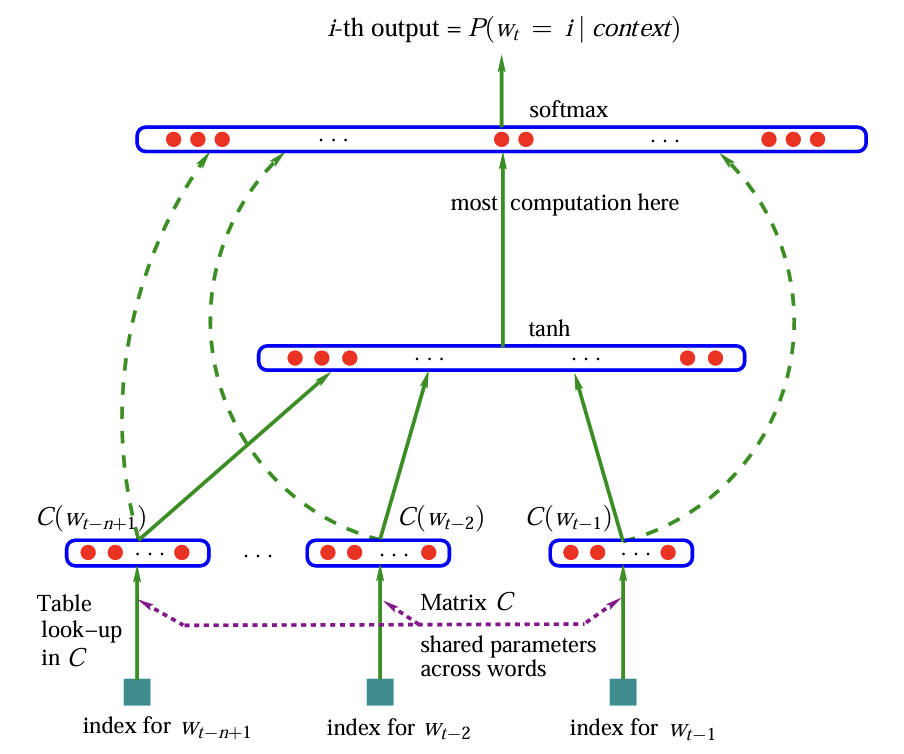

The critical thing here is that you understand the relationship between the equations, the diagrams and the code below. Work through this! Feel free to create new cells to look at the intermediate stages of the representions. Make liberal use of the `.size()` method of tensors to understand the shape of the matrices being used. 

In [ ]:
from typing import Sequence

class NeuralTrigram(nn.Module):
    def __init__(self, vocab_size, embeddings_size, hidden_size):
        super(NeuralTrigram, self).__init__()

        # This is an embedding layer that maps indices to their corresponding embedding
        self.embed = nn.Embedding(vocab_size, embeddings_size)

        # This is a linear layer that maps a vector of size 2*embedding_size to one of hidden_size
        # This is then fed into a tanh nonlinearity
        self.linear = nn.Linear(2*embeddings_size, hidden_size)

        # This is a layer that linearly transforms a vector of hidden size to one of vocab size
        # This is used to compute simulated logits!
        self.output = nn.Linear(hidden_size, vocab_size)

        # A softmax classifier turns our simulated logits into a (log) probability distribution
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, C : torch.Tensor):

        # Get our embeddings for each word in our context
        embeds = self.embed(C)

        # Concatenate our context vectors, to get one long context vector
        context = embeds.view(-1)

        # Apply our transformations
        h = F.tanh(self.linear(context))
        logits = self.output(h)

        return self.softmax(logits)

Note that unlike in the Logistic Regression activity, I'm not building tensors and wrapping them in `nn.Parameter` calls. Instead, I'm using pre-constructed "building blocks" for neural network layers provided by the `torch.nn` module. Documentation for this module will preview some non-linear layers we'll be looking at soon (RNNs and Self-Attention layers!). In this way, constructing a NN architecture is like putting together lego blocks. The key trick is making sure the connectors fit together properly (i.e., that the dimensions are correct!)

To show that this works the same (i.e., automatically constructs our parameters!), we can look at them directly!

In [ ]:
emma_N3G = NeuralTrigram(len(vocab), 100, 100)

for name, param in emma_N3G.named_parameters():
    print(name, param)

Or we can just look at their shapes! 

In [ ]:
for name, param in emma_N3G.named_parameters():
    print(name, param.size())

Make sure you understand what these represent!

Now, we need to train and evaluate. The code below should look familiar to our training code for, say, logistic regression with a few extra changes. Note that this takes time, especially since this is running on a CPU rather than a GPU (hardware specially built to do the matrix multiplication that underlies everything going on here!)

If you run this, be aware that it will take time. On my machine (for reference), each epoch takes about 70s to run. For a sense of scale, the kinds of networks I train in my research take from hours to days to complete a single epoch over their training data, with gpu acceleration. This is the business of modern NLP!

In [ ]:
def ngram_ppl(model, data, n):
    loss = 0
    num_batches = 0
    with torch.no_grad():
        for *c, w in get_ngrams(data, 3):
            C = torch.tensor(c)
            w_v = torch.tensor(w)
            loss += nll(model(C), w_v)
            num_batches +=1
    return torch.exp(loss/num_batches)

In [ ]:
import time

num_epochs = 10

nll = nn.NLLLoss()
optimizer = torch.optim.SGD(emma_N3G.parameters(), lr = 0.01)

for epoch in range(num_epochs):
    start_time = time.time()
    total_loss = 0
    num_batches = 0
    for c1, c2, w in get_ngrams(train_idxs, 3):
        # Turn our inputs into tensors
        C = torch.tensor([c1, c2])
        w_v = torch.tensor(w)

        # run our model forward
        out = emma_N3G(C)

        # Compute our loss
        loss = nll(out, w_v)

        # Compute gradients
        loss.backward()

        # keep track of our total loss/epoch
        total_loss += loss.item()
        num_batches += 1

        # Update our parameters
        optimizer.step()

        # Clean up for the next iteration
        optimizer.zero_grad()

    end_time = time.time()
    print("epoch {} | train_loss = {:.3f} | valid_ppl = {:.3f} | {:.3f}s".format(epoch, 
                                                                       total_loss/num_batches, 
                                                                       ngram_ppl(emma_N3G, valid_idxs, 3), end_time-start_time))

**Bonus:** One thing keeping the model slow is that we are not *batching*, a concept you saw in the logistic regression activity. As an exercise, it might be useful to modify the code above to allow for batched processing. Look through the previous activity and the PyTorch documentation for reference! My advice is to be carefuly about your matrix dimensions!